In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
#!/usr/bin/env python
# coding: utf-8
# 모델의 reproducibility를 위해 random seed를 고정함
seed_value = 743
print("Train with random seed", seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow.keras import backend as K

Train with random seed 743


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 그래프를 그리기 위한 matplotlib 및 기타 utility 라이브러리를 import함
import pickle
import joblib 
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
# matplotlib를 사용해 그래프를 그릴 때 사용할 글꼴을 설정함
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
from sklearn.metrics import mean_absolute_error

In [4]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화에 사용할 MinMaxScaler import
from sklearn.metrics import mean_squared_error  # MSE 성능 지표를 계산하기 하기 위한 함수 import

# 모델을 구축하기 위한 keras 관련 함수 import
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers

In [5]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [6]:
data_path = '../Merged_Data'

In [7]:
def data_transform(name,time_steps):
    data=pd.read_csv("../Merged_Data/{:s}.csv".format(name))
    
    print("column =",data.columns)
    
    if name.split("x")[-1]=='(Seasonal_Trend)':
        data=data.drop("time",axis=1)
        sequences=[]
        for i in range(len(data) - time_steps + 1):
            sequence = data[i:i+time_steps]
            sequences.append(sequence)
        return np.array(sequences)
    
    return np.array(data[23:])

In [8]:
test_x= data_transform("test_x(Seasonal_Trend)",24)
test_y= data_transform("test_y",24)

column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')


In [9]:
print(test_x.shape, test_y.shape)

(3046, 24, 4) (3046, 1)


In [10]:
from tensorflow.python.keras.models import load_model

models=[]

models.append(load_model('./Saved_Model/Attention_LSTM(Early_Stopping).pt'))
models.append(load_model('./Saved_Model/Dual_Attention_LSTM(Early_Stopping).pt'))
models.append(load_model('./Saved_Model/LSTM(Early_Stopping).pt'))

batch_size=4

model_names=['Attention_LSTM','Dual_Attention_LSTM','LSTM']

In [11]:
def vizualization_save(model_name,train_term,test_y,pred_y):
        font_path = "./NanumGothicBold.ttf"
        fontprop = font_manager.FontProperties(fname=font_path)
    
        plt.figure(figsize=(32, 16))
        plt.plot(np.arange(train_term), test_y[0:train_term], color='red', ls='-', lw=3, label='Real Test Data')
        plt.plot(np.arange(train_term), pred_y[0:train_term], color='blue', ls='--', lw=3, label='Predict Test Data')
        plt.xlabel('[Time]', fontsize=24, fontweight='bold')
        plt.ylabel('[PM10]', fontsize=24, fontweight='bold')
        plt.title('Predict({:s})'.format('Merged'),fontsize=30, weight='bold',fontproperties=fontprop)
        plt.xticks( fontsize=15, fontweight='bold')
        plt.yticks( fontsize=15, fontweight='bold')
        plt.grid(True)

        if not os.path.exists("./model_result({:s})/img(Early_Stopping)/".format(model_name)):
                os.makedirs("./model_result({:s})/img(Early_Stopping)/".format(model_name))

        plt.savefig("./model_result({:s})/img(Early_Stopping)/{:s}.jpg".format(model_name,'Merged_Testset'))
        return

In [12]:
scaler = joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')  # Load MinMaxScaler

In [13]:
def model_test(model,test_x,test_y,batch_size,model_name):
    test_predict = model.predict(test_x, batch_size)

    inv_test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
    inv_test_predict = scaler.inverse_transform(test_predict)

    score1 = Symmetric_mean_absolute_percentage_error(inv_test_y, inv_test_predict)
    score2=mean_squared_error(inv_test_y,inv_test_predict)
    score3=np.sqrt(score2)
    score4=mean_absolute_error(inv_test_y,inv_test_predict)
    
    print("Test SMAPE: " ,100-score1)
    print("Test MSE: " ,score2)
    print("Test RMSE: " ,score3)
    print("Test MAE: " ,score4)

    vizualization_save(model_name,len(inv_test_y),inv_test_y,inv_test_predict)
    
    data = {
                "db_name": '병합',
                "ms_name": '병합',
                "accuracy(SMAPE)": 100 - score1,
                "accuracy(MSE)": score2,
                "accuracy(RMSE)": score3,
                "accuracy(MAE)": score4,
        }
    
    new_data = pd.DataFrame([data])
    new_data.to_csv("./model_result({:s})/Test_Result(Early_Stopping).csv".format(model_name), header=True, index=False, encoding='utf-8-sig')
    
    return

Test SMAPE:  94.50559932952773
Test MSE:  3.3312501620865125
Test RMSE:  1.825171269247495
Test MAE:  1.3718023515023121
Test SMAPE:  94.4294553432766
Test MSE:  4.352453498418649
Test RMSE:  2.0862534597739195
Test MAE:  1.54098620025343
Test SMAPE:  93.64666034440093
Test MSE:  4.351301330107681
Test RMSE:  2.085977308147833
Test MAE:  1.524206117191276


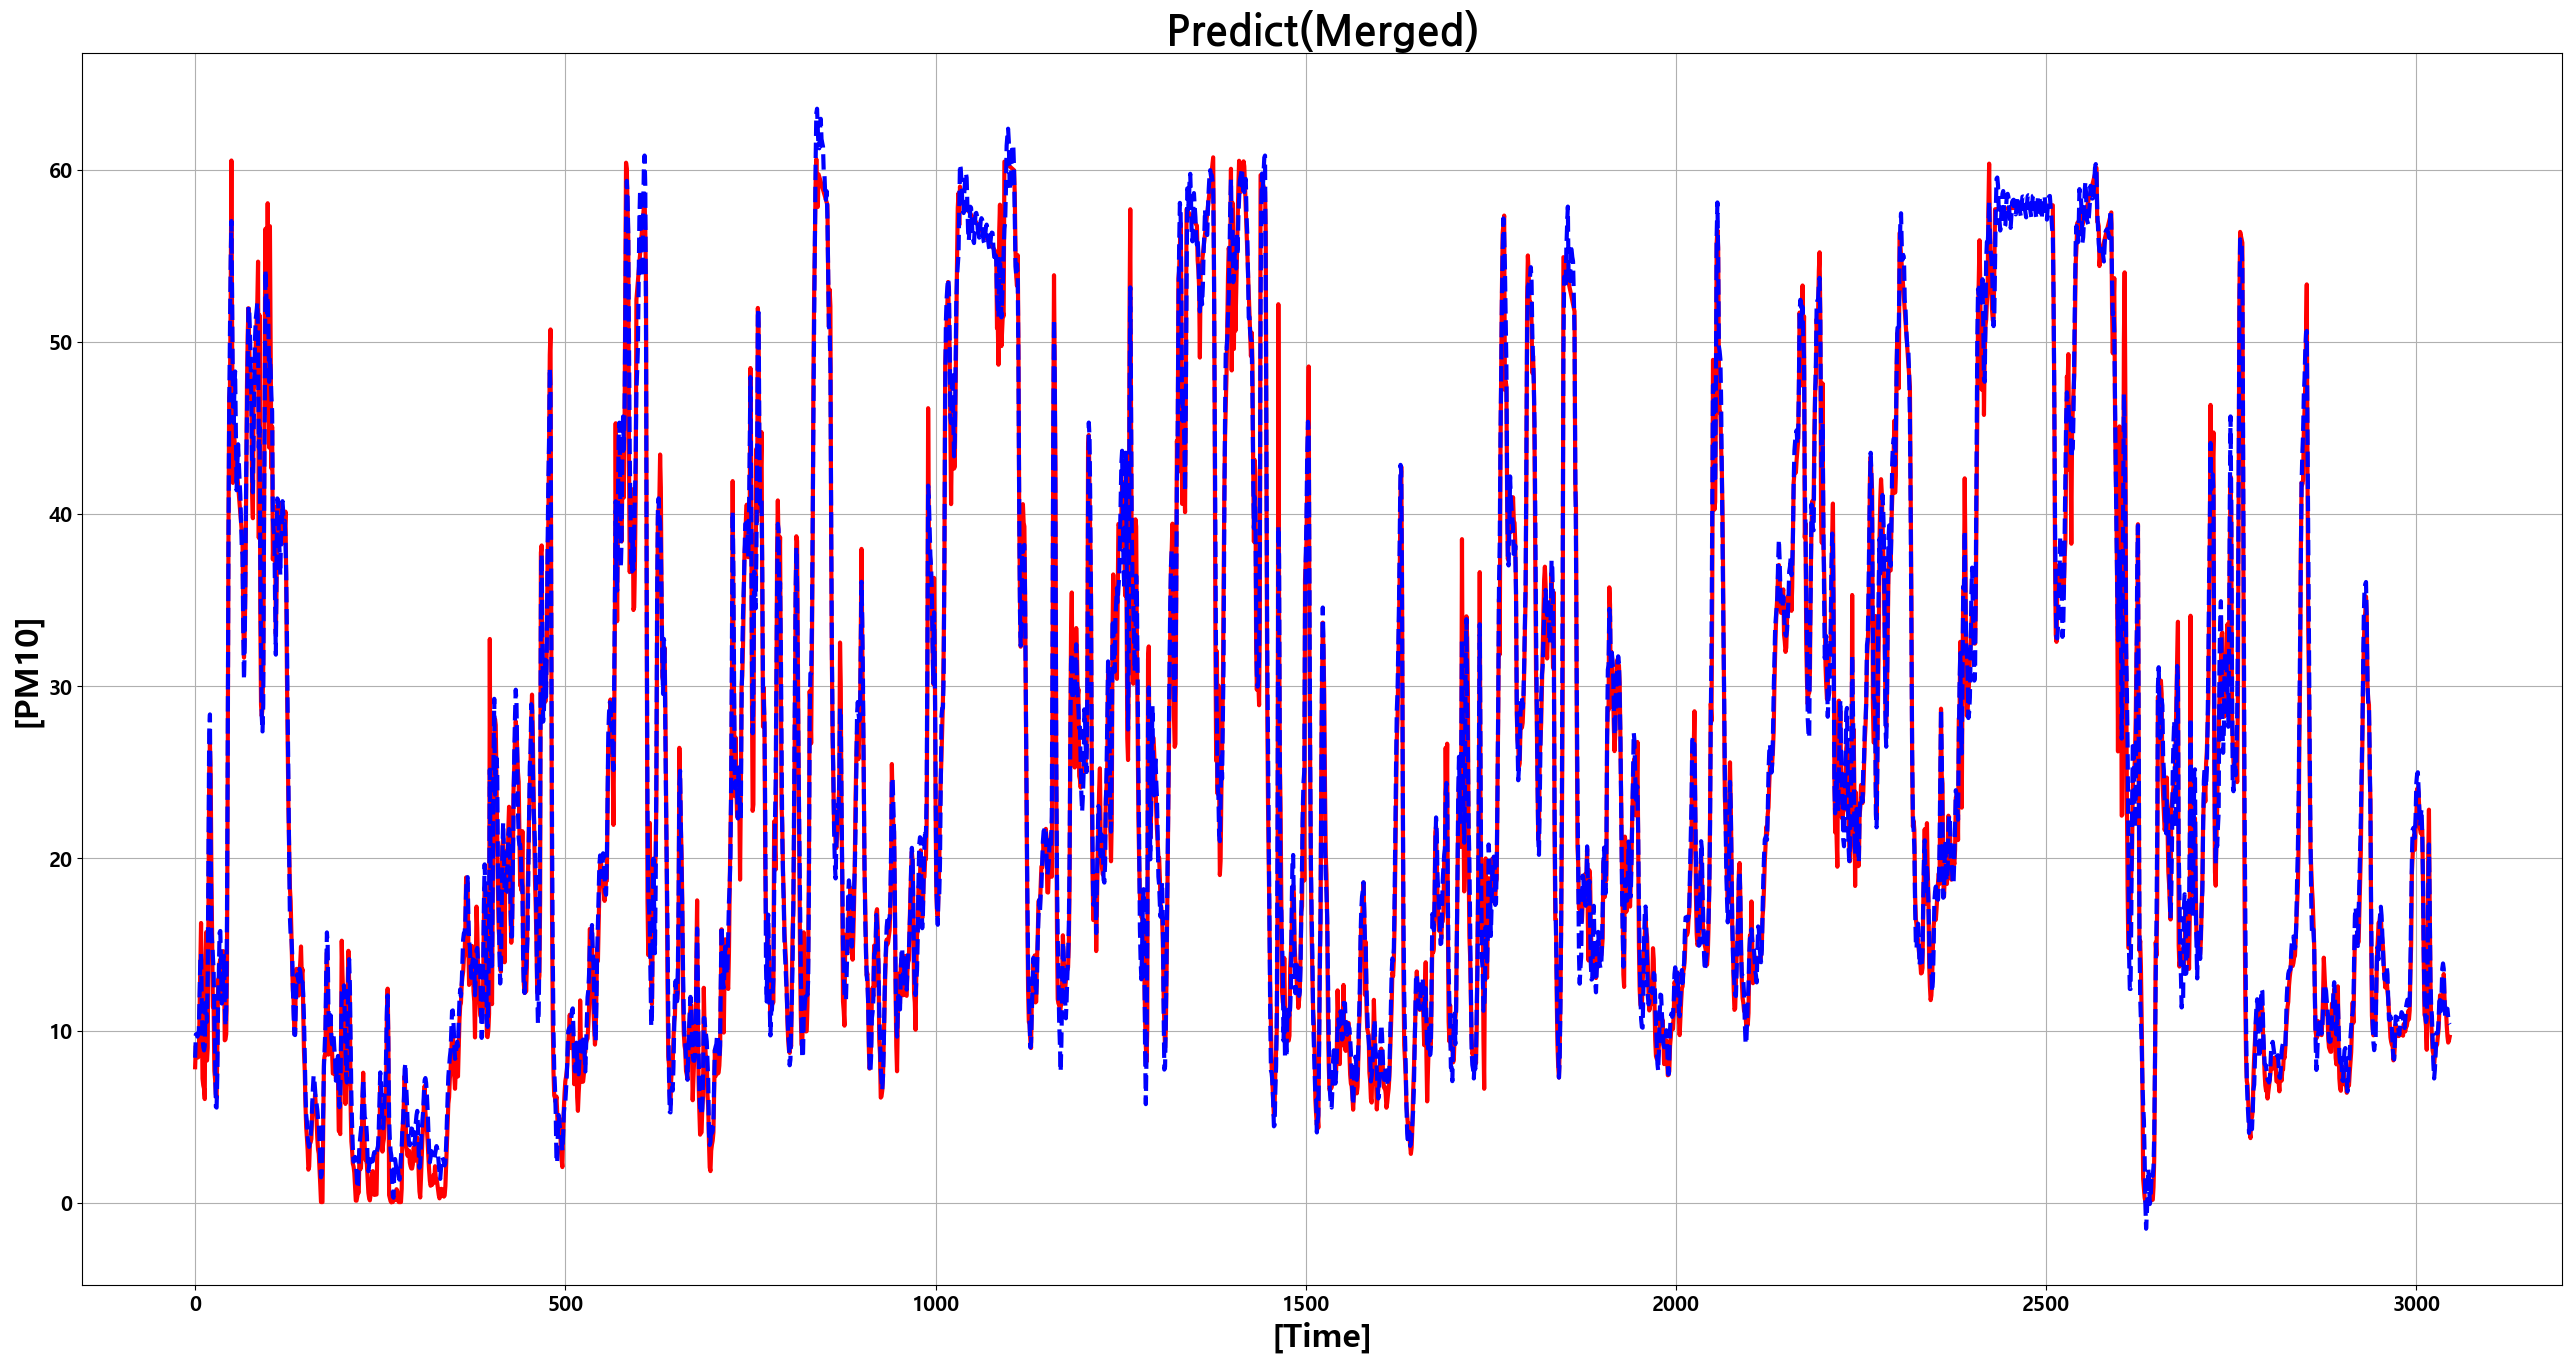

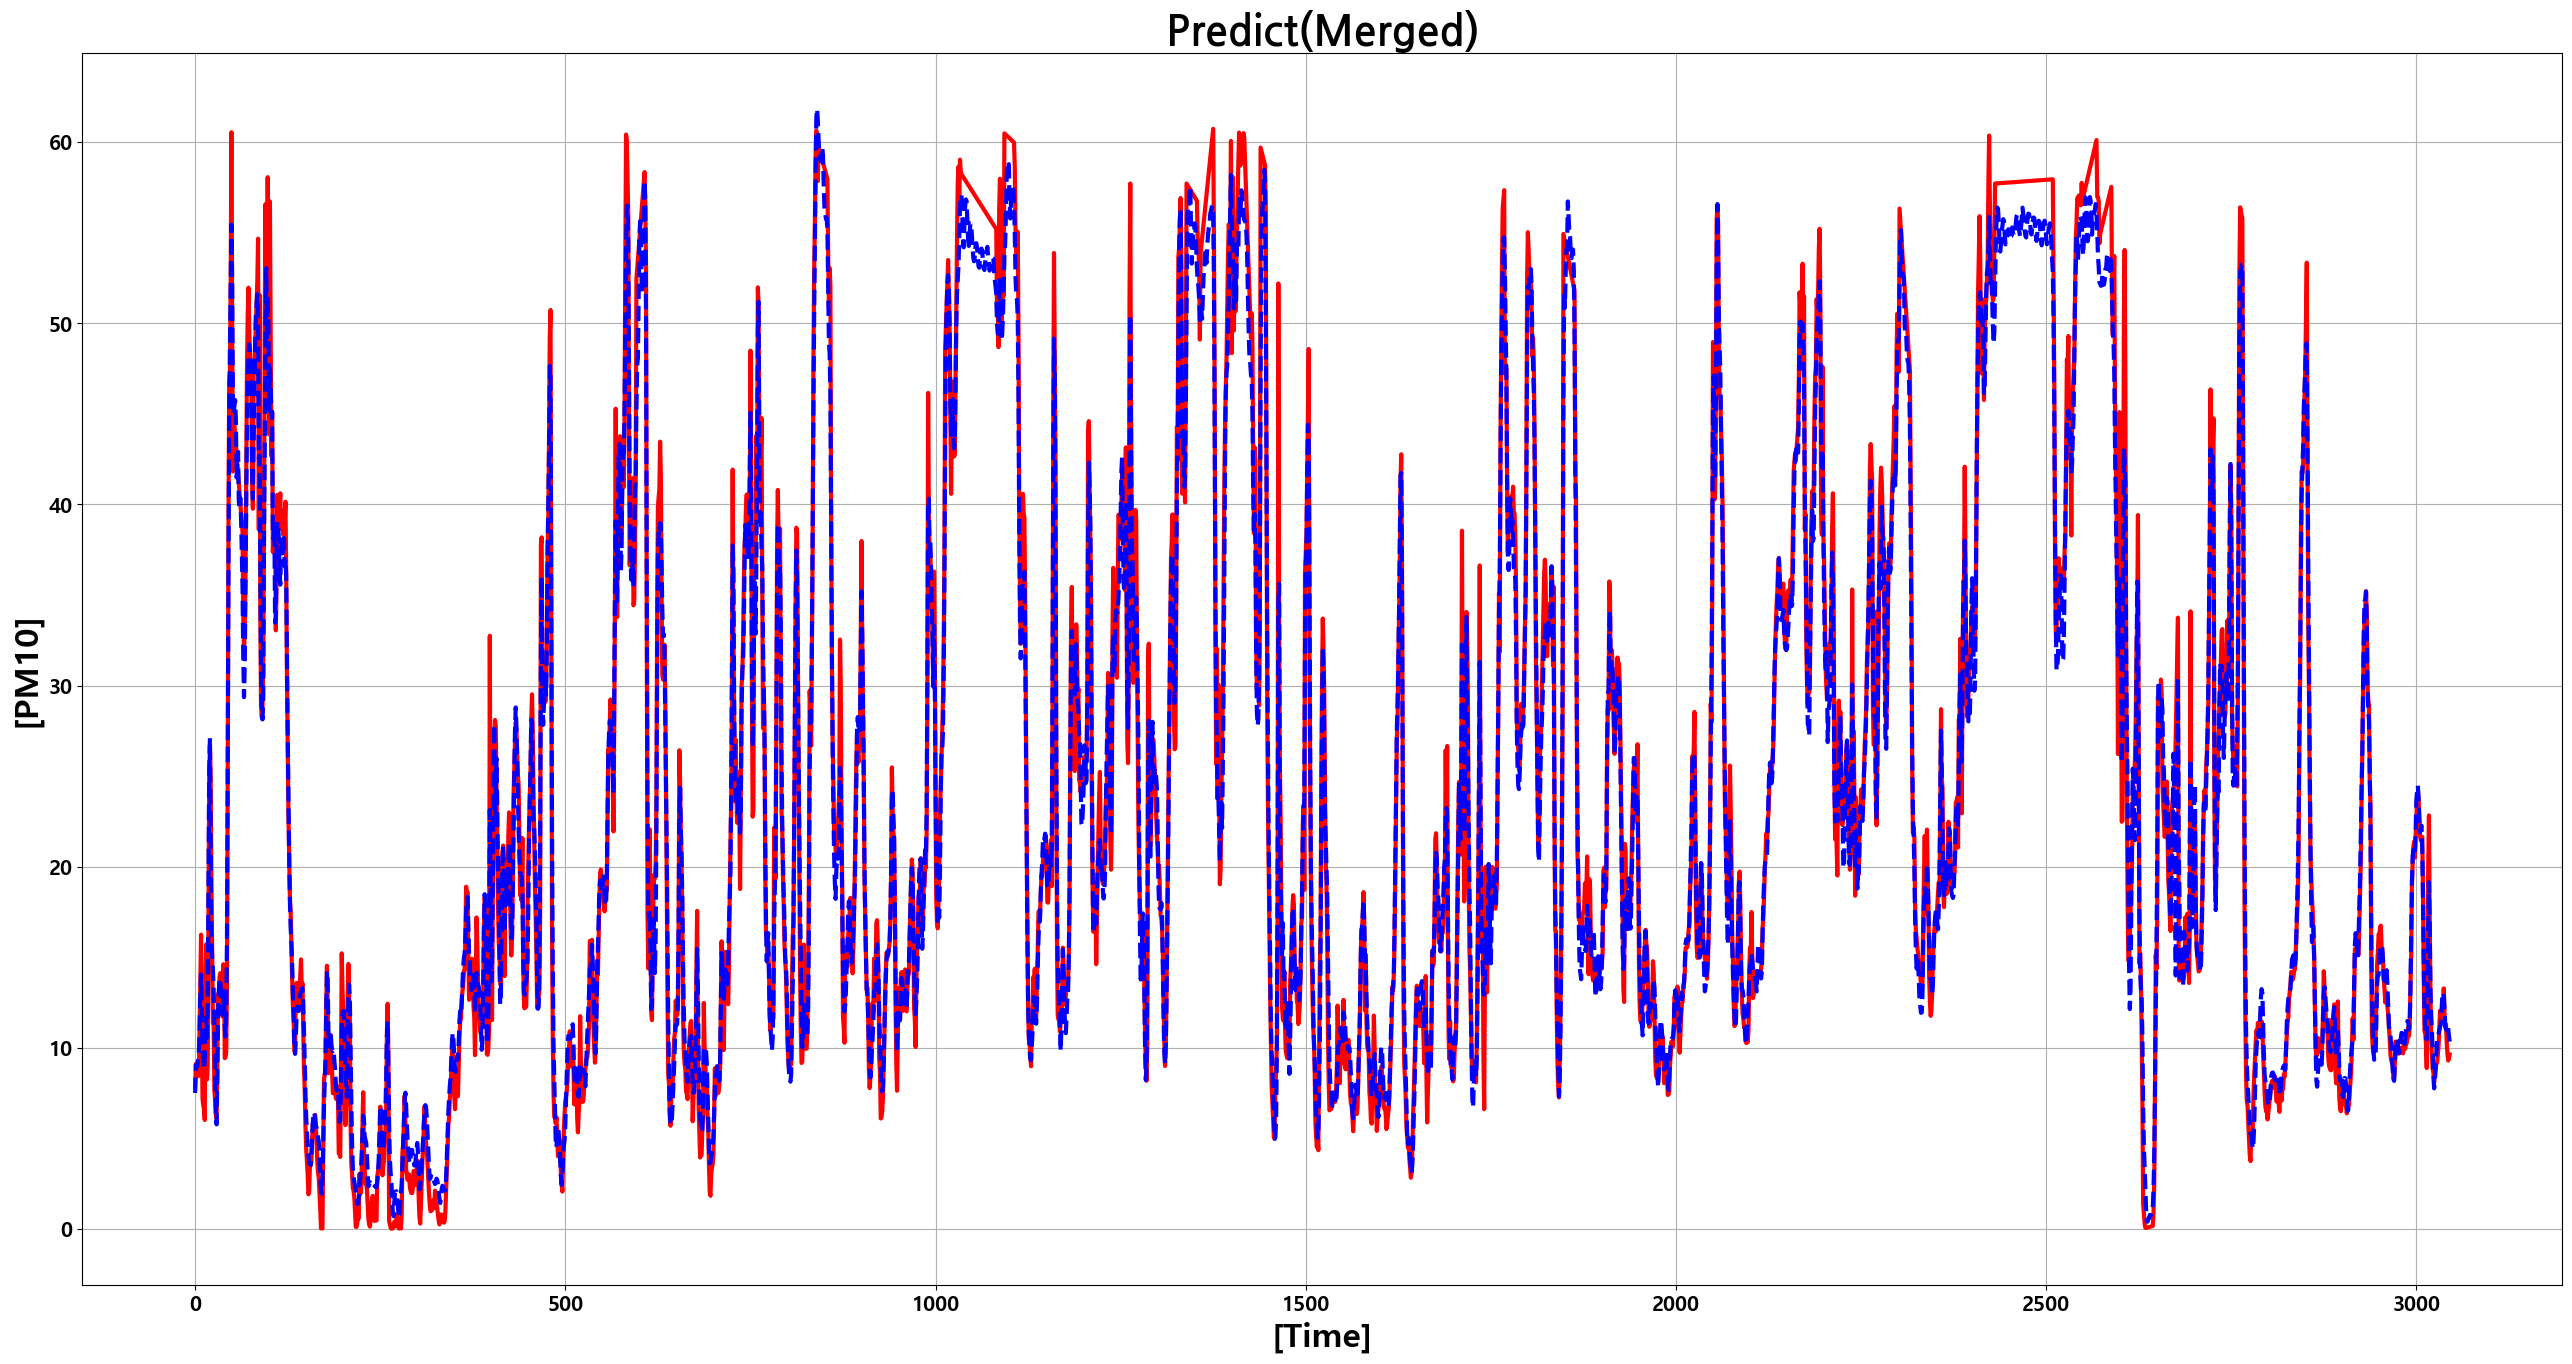

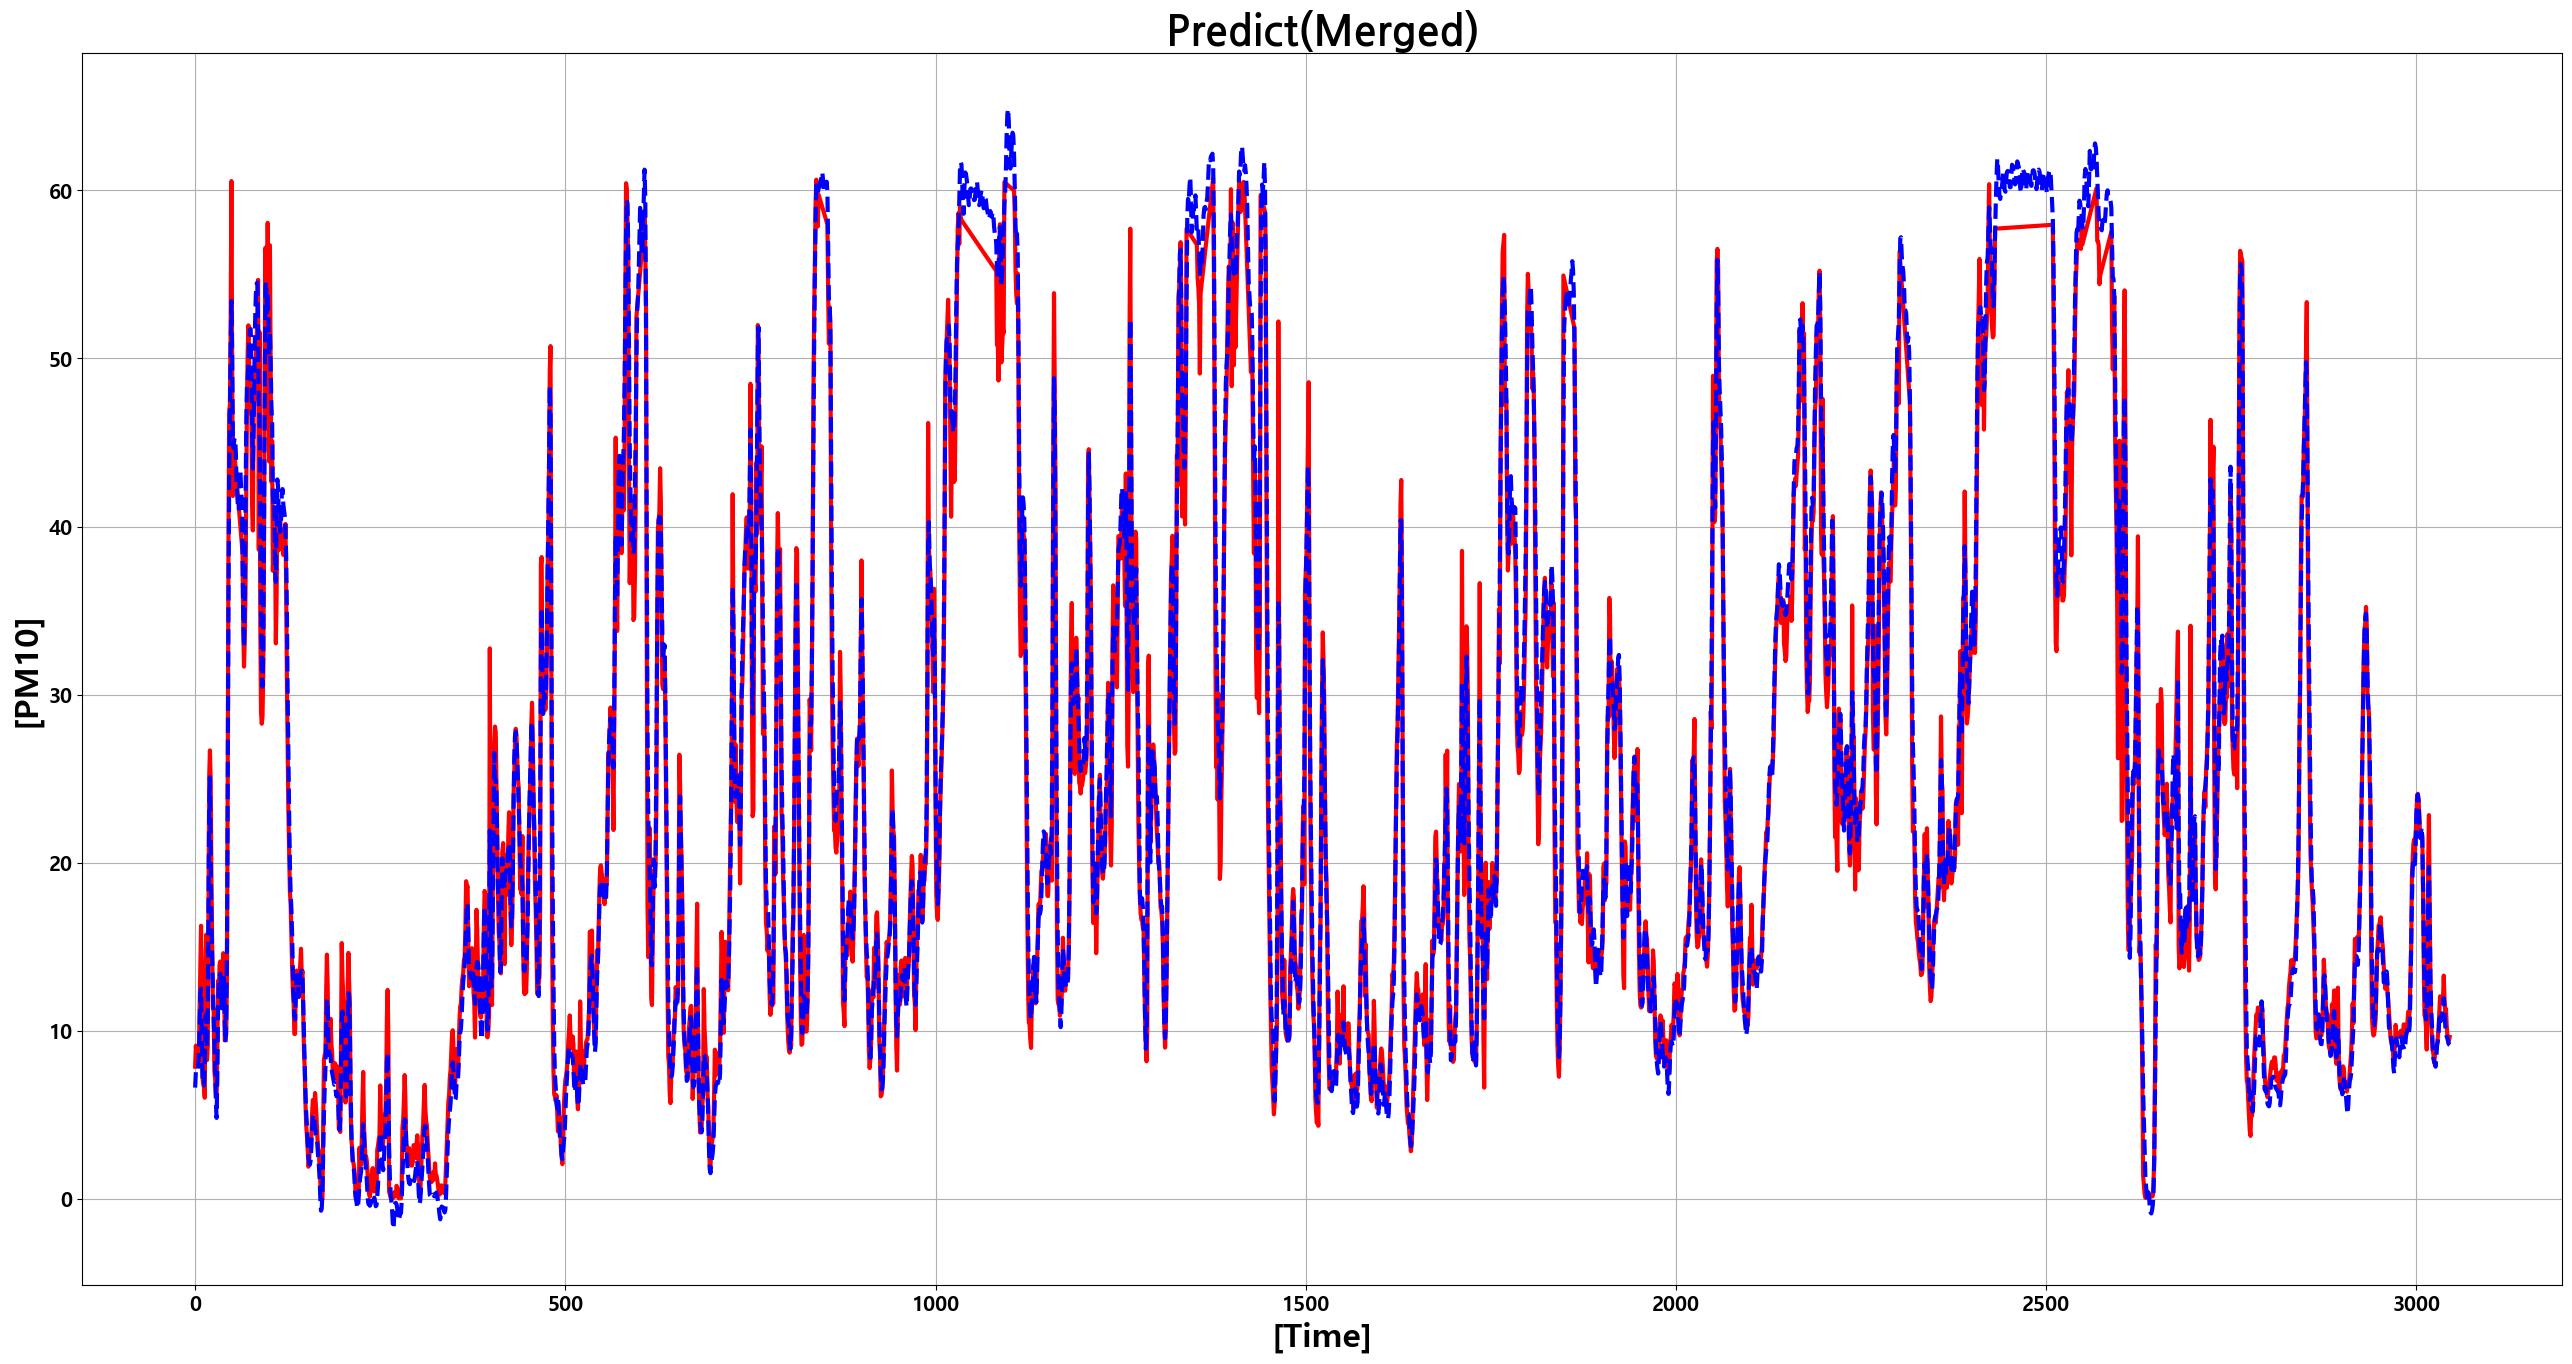

In [14]:
for model,model_name in zip(models,model_names):
    model_test(model,test_x,test_y,batch_size,model_name)